In [10]:
!pip install git+https://github.com/brianbt/btorch
!pip install transformers
!pip install pip install datasets

  Cloning https://github.com/brianbt/btorch to /tmp/pip-req-build-hw8jfwzv
  Running command git clone --filter=blob:none --quiet https://github.com/brianbt/btorch /tmp/pip-req-build-hw8jfwzv
  Resolved https://github.com/brianbt/btorch to commit 10a0e2f09ac4e9dd937843846aa20e3d7d383f95
  Preparing metadata (setup.py) ... done
  Created wheel for btorch: filename=btorch-0.0.1-py3-none-any.whl size=53028 sha256=b26321f9e4754c63ca48165d965b05ab92e8696e2d248f3c8bd382567ba7086b
  Stored in directory: /tmp/pip-ephem-wheel-cache-xz5au4w1/wheels/fa/ef/1e/1248ce8683f1b6fd8e6552260da8c1dcfbb352d899fef03d72
Successfully built btorch


# Import

In [11]:
import torch
from tqdm import tqdm

# Btorch
import btorch
from btorch import nn
import btorch.nn.functional as F

# Hugging Face
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig, AutoModel

# Load dataset

In [12]:
# https://huggingface.co/datasets/emotion
# this dataset have 6 classes
idx2label = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

dataset = load_dataset("emotion")
print(dataset)
# Lets check how one datapoint looks like
print(next(iter(dataset['train'])))

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
{'text': 'i didnt feel humiliated', 'label': 0}


# Create HuggingFace BERT 🤗 

In [13]:
#https://huggingface.co/bert-base-uncased
model_name = 'bert-base-uncased'

# You can check the config parameter options from the below links
#https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/configuration#transformers.PretrainedConfig
#https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/bert#transformers.BertConfig
config = AutoConfig.from_pretrained(
    model_name, 
    output_hidden_states = True,
    output_attention = True,
    hidden_dropout_prob = 0.2,
) 
print(config)

# Use above config to create our BERT model
pretrain_model = AutoModel.from_pretrained(
    model_name,
    config = config
)

# Create a BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

## Quick tutor for tokenizer usgage

In [14]:
x = ['i didnt feel humiliated',
     'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
     'im grabbing a minute to post i feel greedy wrong']
y = [0,
     0,
     3]

In [15]:
# Since each data in one batch must have same size. We do padding and truncation such that the length is 10 for each sentence.
# The padding idx will be ``0``
tokens = tokenizer(x, padding=True, truncation=True, max_length=10)
display(tokens['input_ids'])


[[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0],
 [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 102],
 [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 102]]

In [16]:
# This is either 0 or 1.
# Remeber training data for BERT have two parts. 
# The first is indicated as 0, the second is indicated as 1
display(tokens['token_type_ids'])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [17]:
# This is attention mask.
# 0 means attention should be see those words
# Becoz those words is padded
display(tokens['attention_mask'])

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

## Quick tutor for BERT usgage

In [18]:
# here (N,T) is (3, max_length=10)
inputs = torch.tensor(tokens['input_ids'])
attn_masks = torch.tensor(tokens['attention_mask'])
# Hugging Face BERT will produce three thing for us base on how we set the config
out = pretrain_model(inputs, attention_mask=attn_masks)
print(out.keys())
# hidden_states is all the hidden_states #List[(N,T,D)]
# last_hidden_state is the last one
# pooler_output is output of tanh(Linear(last_hidden_state))
# torch.equal(out['hidden_states'][-1], out['last_hidden_state']) -> True
# Note that ``out['last_hidden_state'][:,0,:]`` is the CLS token and used for sentence level prediction

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])


In [19]:
out['last_hidden_state'][:,0,:].shape

torch.Size([3, 768])

In [20]:
out = pretrain_model(inputs, attention_mask=attn_masks)
torch.equal(out['hidden_states'][-1], out['last_hidden_state'])

True

# Wrap tokenizer and BERT in Btorch

Here we will freeze the pretrained BERT.  
Use the `last_hidden_state[:,0,:]` and `last_hidden_state[:,1:,:]` to perform multiHeadAttn.  
Pass the Attn_output to Linear layers and do classification.  
Use the attn_weight to find out which token has contribute to the classification task.



In [21]:
class Bert(nn.Module):
    def __init__(self, pretrain_model, tokenizer, classes, hidden_dim, freeze_pretrain=True):
        super(Bert, self).__init__()
        self.pretrain_model = pretrain_model
        self.tokenizer = tokenizer
        self.embed_size = pretrain_model.embeddings.word_embeddings.embedding_dim
        self.classes = classes
        self.hidden_dim = hidden_dim
        self.l1 = nn.Linear(self.embed_size, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, classes)
        self.last_attn = nn.MultiheadAttention(self.embed_size, 8, batch_first=True)
        if freeze_pretrain:
          btorch.utils.trainer.freeze(self.pretrain_model)
    def forward(self, x):
        x = self.tokenizer(x, padding=True, truncation=True, max_length=50)
        inputs = torch.tensor(x['input_ids'], device=self.device())
        attn_masks = torch.tensor(x['attention_mask'], device=self.device())
        pred = self.pretrain_model(inputs, attention_mask=attn_masks)
        last_hidden_CLS = pred['last_hidden_state'][:,0,:].unsqueeze(1) #(N,1,E)

        last_hidden_rest = pred['last_hidden_state'][:, 1:, :] # (N,T-1,E)
        # For a binary mask, a True value indicates that the corresponding key value will be ignored for the purpose of attention.
        # Here, we want to mask all padding
        atten_mask_pad = (inputs == 0)[:,1:] #(N,T-1)
        last_attn_out, last_attn_w = self.last_attn(last_hidden_CLS, last_hidden_rest, last_hidden_rest,
                                                    key_padding_mask=atten_mask_pad) #(N,1,E), (N,1,T-1)
        last_attn_out = last_attn_out.squeeze(1)
        out = torch.relu(self.l1(last_attn_out))
        out = self.l2(out)

        return out, last_attn_w
    
    @classmethod
    def train_epoch(cls, net, criterion, trainloader, optimizer, epoch_idx, device='cuda', config=None, **kwargs):
        """This is the very basic training function for one epoch. Override this function when necessary
            
        Returns:
            (float or dict): train_loss
        """
        net.train()
        train_loss = 0
        pbar = tqdm(enumerate(trainloader), total=len(trainloader), disable=(kwargs.get("verbose", 1) == 0))
        batch_idx = 1
        for batch_idx, (inputs) in pbar:
            text = inputs['text']
            targets = inputs['label'].to(net.device())
            optimizer.zero_grad()
            predicted = net(text)[0]
            loss = criterion(predicted, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            pbar.set_description(
                f"epoch {epoch_idx + 1} iter {batch_idx}: train loss {loss.item():.5f}.")
        return train_loss / (batch_idx + 1)

    @classmethod
    def test_epoch(cls, net, criterion, testloader, scoring=None, epoch_idx=0, device='cuda', config=None, **kwargs):
        """This is the very basic evaluating function for one epoch. Override this function when necessary

        Args:
            scoring (Callable, optional): A scoring function that take in ``y_true`` and ``model_output``.
              Usually, this is your evaluation metric, like accuracy.
              If provided, this method return a dict that include both loss and score.
              This scoring function should return the **sum** (set ``reduction=sum``) of the score of a batch.
              The function signature must be ``scoring(y_true=, model_output=)``.
              
        Returns:
            (float or dict): eval_loss
        """
        net.eval()
        test_loss = 0
        test_score = 0
        total = 0
        with torch.inference_mode():
            for batch_idx, (inputs) in enumerate(testloader):
                text = inputs['text']
                targets = inputs['label'].to(net.device())
                predicted = net(text)[0]
                loss = criterion(predicted, targets)
                test_loss += loss.item()
                if scoring is not None:
                    score = scoring(model_output=predicted, y_true=targets)
                    test_score += score
                total += len(text)
        if scoring is None:
            return test_loss / (batch_idx + 1)
        return {'loss': test_loss / (batch_idx + 1), 'score': test_score / total}

    @classmethod
    def predict_(cls, net, loader, device='cuda', config=None):
        """This is the very basic predicting function. Override this function when necessary
            
        Returns:
            (list or dict): predict results
        """
        net.to(device)
        net.eval()
        out = {}
        with torch.inference_mode():
            for batch_idx, (inputs) in enumerate(loader):
                text = inputs['text']
                predicted = net(text)[0]
                preds_raw = predicted.max(1)[1]
                for i in range(len(preds_raw)):
                    out[text[i]] = idx2label[preds_raw[i]]
        return out
    @classmethod
    def overfit_small_batch_(cls, net, criterion, dataset, optimizer, config=None):
        """This is a helper function to check if your model is working by checking if it can overfit a small dataset.
        
        Note:
            It uses .train_epoch().
            
            This function will affect the model weights and all other training-related setting/parameters.
         
        """
        dataset = torch.utils.data.Subset(dataset, [0, 1, 2, 3])
        loader = DataLoader(dataset, 2)
        loss_history = []
        for epoch in range(100):
            train_loss = cls.train_epoch(net, criterion, loader, optimizer, epoch, config['device'], config, verbose=0)
            loss_history.append(train_loss)
        print(loss_history)
        # del net_test
        try:
            last_loss = loss_history[-1].item()
            if last_loss < 1e-5:
                print(
                    "It looks like your model is working. Please double check the loss_history to see whether it is overfitting. Expected to be overfit.")
        except Exception:
            pass
        print("Please check the loss_history to see whether it is overfitting. Expected to be overfit.")

In [22]:
from torch.utils.data import DataLoader

In [23]:
def accuarcy(model_output, y_true, reduction='sum'):
    y_pred = model_output.max(1)[1]
    out = (y_pred == y_true).float().sum().item()
    return out
  
def predict_directly(net, x):
    out = net(x)
    preds_raw = out[0].max(1)[1]
    preds = {}
    for i in range(len(preds_raw)):
        preds[x[i]] = idx2label[preds_raw[i]]
    return preds

## Init Model

In [48]:
# Model
model = Bert(pretrain_model, tokenizer, 6, 512, freeze_pretrain=True)

# Loss & Optimizer & Config
model._config['max_epoch'] = 30
model._lossfn = nn.CrossEntropyLoss()
model._optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-3)
model._lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model._optimizer, model._config['max_epoch'])


# Set GPU
device = model.auto_gpu()

auto_gpu: using GPU (Tesla P100-PCIE-16GB)


In [49]:
# model.overfit_small_batch(dataset['train'])

In [50]:
# FIT
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
model.fit(dataset['train'], validation_data=dataset['validation'], batch_size=256, workers=4, scoring=accuarcy)

epoch 1 iter 62: train loss 1.17994.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s] 


Epoch 0: Training loss: 2.968769864430503. Testing loss: {'loss': 1.1314822081327438, 'score': 0.5945}


epoch 2 iter 62: train loss 0.95049.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 1: Training loss: 1.0083359962417966. Testing loss: {'loss': 0.7658614906668663, 'score': 0.743}


epoch 3 iter 62: train loss 0.78245.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 2: Training loss: 0.7675675418641832. Testing loss: {'loss': 0.5721869095563888, 'score': 0.805}


epoch 4 iter 62: train loss 0.73573.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 3: Training loss: 0.6957168664251056. Testing loss: {'loss': 0.5782942697703838, 'score': 0.804}


epoch 5 iter 62: train loss 0.59003.: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch 4: Training loss: 0.6467148075028072. Testing loss: {'loss': 0.5091140598058701, 'score': 0.825}


epoch 6 iter 62: train loss 0.58871.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 5: Training loss: 0.6256072762466612. Testing loss: {'loss': 0.5118391069322824, 'score': 0.8265}


epoch 7 iter 62: train loss 0.67627.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 6: Training loss: 0.6081361193505544. Testing loss: {'loss': 0.5101500227078796, 'score': 0.8275}


epoch 8 iter 62: train loss 0.49524.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 7: Training loss: 0.6058357589774661. Testing loss: {'loss': 0.4782592851743102, 'score': 0.828}


epoch 9 iter 62: train loss 0.66846.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 8: Training loss: 0.5796748797098795. Testing loss: {'loss': 0.4724682058393955, 'score': 0.836}


epoch 10 iter 62: train loss 0.51720.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 9: Training loss: 0.5670536666635483. Testing loss: {'loss': 0.48946982476115225, 'score': 0.825}


epoch 11 iter 62: train loss 0.61112.: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch 10: Training loss: 0.5675762097040812. Testing loss: {'loss': 0.49873720878362654, 'score': 0.822}


epoch 12 iter 62: train loss 0.74963.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 11: Training loss: 0.5615776010922023. Testing loss: {'loss': 0.45264782138168813, 'score': 0.8425}


epoch 13 iter 62: train loss 0.61633.: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch 12: Training loss: 0.542266077938534. Testing loss: {'loss': 0.4497188519611955, 'score': 0.8445}


epoch 14 iter 62: train loss 0.40047.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 13: Training loss: 0.5318125935774001. Testing loss: {'loss': 0.40412843685224653, 'score': 0.8585}


epoch 15 iter 62: train loss 0.66100.: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 14: Training loss: 0.5266223516729143. Testing loss: {'loss': 0.4389627384841442, 'score': 0.843}


epoch 16 iter 62: train loss 0.45012.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 15: Training loss: 0.5180978935862345. Testing loss: {'loss': 0.39061033572256565, 'score': 0.859}


epoch 17 iter 62: train loss 0.49442.: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch 16: Training loss: 0.4930305911435021. Testing loss: {'loss': 0.40567453517019747, 'score': 0.855}


epoch 18 iter 62: train loss 0.60101.: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch 17: Training loss: 0.48425399736752583. Testing loss: {'loss': 0.4061247553490102, 'score': 0.8495}


epoch 19 iter 62: train loss 0.43997.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 18: Training loss: 0.4756079377636077. Testing loss: {'loss': 0.3990077238082886, 'score': 0.8525}


epoch 20 iter 62: train loss 0.43277.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 19: Training loss: 0.46248258295513334. Testing loss: {'loss': 0.3860270630531013, 'score': 0.8645}


epoch 21 iter 62: train loss 0.38124.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 20: Training loss: 0.43711630692557685. Testing loss: {'loss': 0.38035083965957167, 'score': 0.862}


epoch 22 iter 62: train loss 0.41824.: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch 21: Training loss: 0.4403748100712186. Testing loss: {'loss': 0.3576669943444431, 'score': 0.875}


epoch 23 iter 62: train loss 0.53164.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 22: Training loss: 0.4274433080166105. Testing loss: {'loss': 0.3942038837224245, 'score': 0.853}


epoch 24 iter 62: train loss 0.55066.: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch 23: Training loss: 0.419776846965154. Testing loss: {'loss': 0.37320304359868167, 'score': 0.8655}


epoch 25 iter 62: train loss 0.30268.: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch 24: Training loss: 0.4050144595759256. Testing loss: {'loss': 0.3480694276113063, 'score': 0.8735}


epoch 26 iter 62: train loss 0.34393.: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]


Epoch 25: Training loss: 0.3893360618561033. Testing loss: {'loss': 0.3493854692615569, 'score': 0.867}


epoch 27 iter 62: train loss 0.30534.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 26: Training loss: 0.37858667733177304. Testing loss: {'loss': 0.34079900888353587, 'score': 0.8735}


epoch 28 iter 62: train loss 0.46630.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 27: Training loss: 0.37173253013974145. Testing loss: {'loss': 0.3381218536235392, 'score': 0.871}


epoch 29 iter 62: train loss 0.29041.: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch 28: Training loss: 0.3706433465556493. Testing loss: {'loss': 0.33594237675517796, 'score': 0.8785}


epoch 30 iter 62: train loss 0.42442.: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch 29: Training loss: 0.3670397727262406. Testing loss: {'loss': 0.33652917583845554, 'score': 0.875}


In [51]:
model.evaluate(dataset['test'], scoring=accuarcy)

{'loss': 0.3481059001814574, 'score': 0.869}

In [74]:
idx2label = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
x = ['I am sad', 'I am happy', 'i stopped feeling cold and began feeling hot', 
     'what the heck is this', "i don't care what you do", 'I love you 3000', 'I love you in every universe']
y = [0, 1, 3, 4, 3, 2, 2]
preds = predict_directly(model, x)
preds

{'I am sad': 'sadness',
 'I am happy': 'joy',
 'i stopped feeling cold and began feeling hot': 'anger',
 'what the heck is this': 'anger',
 "i don't care what you do": 'anger',
 'I love you 3000': 'anger',
 'I love you in every universe': 'sadness'}

Now we try to visualize which word contribute to the prediction.  
The higher attn weight tell us which token is important.  
For some unknown reason, the attn is lag by one word.  
But still it shows which is the important word.

0 0
Prediction: sadness. Ground-Truth: sadness
Prediction: 0. Ground-Truth: 0
I am sad


[('0_i', 0.041227624), ('1_am', 0.69789195), ('2_sad', 0.12634642)]

1 1
Prediction: joy. Ground-Truth: joy
Prediction: 1. Ground-Truth: 1
I am happy


[('0_i', 0.042612217), ('1_am', 0.6487813), ('2_happy', 0.13144785)]

3 2
Prediction: anger. Ground-Truth: anger
Prediction: 3. Ground-Truth: 3
i stopped feeling cold and began feeling hot


[('0_i', 0.024852218),
 ('1_stopped', 0.027517088),
 ('2_feeling', 0.4777208),
 ('3_cold', 0.033971418),
 ('4_and', 0.015550555),
 ('5_began', 0.02346829),
 ('6_feeling', 0.2995329),
 ('7_hot', 0.050451487)]

4 3
Prediction: anger. Ground-Truth: fear
Prediction: 3. Ground-Truth: 4
what the heck is this


[('0_what', 0.06641406),
 ('1_the', 0.08870229),
 ('2_heck', 0.06578631),
 ('3_is', 0.13839799),
 ('4_this', 0.52843213)]

3 4
Prediction: anger. Ground-Truth: anger
Prediction: 3. Ground-Truth: 3
i don't care what you do


[('0_i', 0.1186454),
 ('1_don', 0.10640065),
 ("2_'", 0.17390597),
 ('3_t', 0.04012368),
 ('4_care', 0.11071235),
 ('5_what', 0.14600022),
 ('6_you', 0.06022846),
 ('7_do', 0.032183893)]

2 5
Prediction: anger. Ground-Truth: love
Prediction: 3. Ground-Truth: 2
I love you 3000


[('0_i', 0.13546982),
 ('1_love', 0.05649385),
 ('2_you', 0.5884026),
 ('3_3000', 0.12832159)]

2 6
Prediction: sadness. Ground-Truth: love
Prediction: 0. Ground-Truth: 2
I love you in every universe


[('0_i', 0.18178302),
 ('1_love', 0.07297179),
 ('2_you', 0.07618167),
 ('3_in', 0.05108311),
 ('4_every', 0.048677504),
 ('5_universe', 0.42384768)]

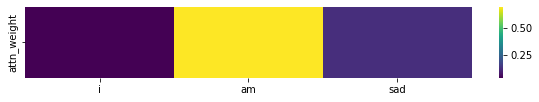

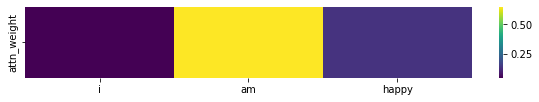

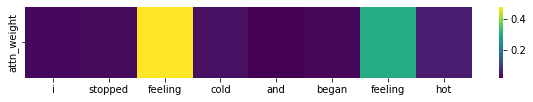

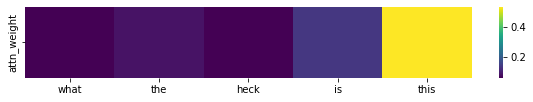

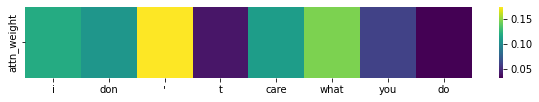

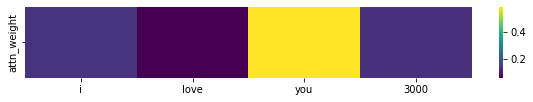

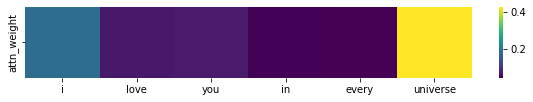

In [75]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt


pred, w = model(x)
for idx in range(0, len(x)):
    print(y[idx], idx)
    print(f"Prediction: {idx2label[pred[idx].argmax().item()]}. Ground-Truth: {idx2label[y[idx]]}")
    print(f"Prediction: {pred[idx].argmax().item()}. Ground-Truth: {y[idx]}")
    print(x[idx])
    w_pure = w[idx][w[idx] !=0 ][1:].cpu().detach().numpy()
    tokens_pure = tokenizer.tokenize(x[idx])
    tokens = [f"{i}_{tokens_pure[i]}" for i in range(len(tokens_pure))]
    full = list(zip(tokens, w_pure))
    display(full)

    out = []
    out.append(list(full[0]))
    for i in range(1, len(full)):
        if full[i][0][:2] == '##':
            out[-1][0] += full[i][0][2:]
            out[-1][1] += full[i][1]
        else:
            out.append(list(full[i]))
    sorted(out, key=lambda out: out[1], reverse=True)

    
    df = pd.DataFrame(w_pure, index=tokens_pure, columns=['attn_weight'])
    plt.figure(figsize=(10,1.3))
    fig = sns.heatmap(df.T, fmt="g", cmap='viridis',xticklabels=tokens_pure)
    fig.get_figure().savefig("out.png",bbox_inches='tight', dpi=300) 

    # break